# Configure notebook to R

In [2]:
# activate R magic
%load_ext rpy2.ipython

# Libraries

In [4]:
%%R
#install.packages("RMySQL")
#install.packages("dplyr")

NULL


In [5]:
%%R
library(RMySQL)
library(dplyr)

R[write to console]: Loading required package: DBI

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Database Connection

In [6]:
%%R
# 2. Settings
db_user <- "fina_4359_u3548379"
db_password <- "856e7"
db_host <- "147.8.122.231"

In [7]:
%%R
dbQuery <- function(query) {
  con <- dbConnect(MySQL(), host = db_host, user = db_user, password = db_password)
  result <- dbGetQuery(con,query)
  on.exit(dbDisconnect(con))
  return(result)  
}

pop <- dbQuery("select date, pop_home, pop_not_home from writeable_fina_4359_u3548379.visits")
summary(pop)

     date              pop_home        pop_not_home     
 Length:89          Min.   :4377163   Min.   :14590351  
 Class :character   1st Qu.:4714674   1st Qu.:18270339  
 Mode  :character   Median :4822394   Median :19918200  
                    Mean   :4829720   Mean   :20365977  
                    3rd Qu.:4928940   3rd Qu.:22058147  
                    Max.   :5252801   Max.   :27553792  


In [8]:
%%R
dbQuery("select * from writeable_fina_4359_u3548379.visits limit 10")

   pop_home pop_not_home     trips    trips1 trips1to3 trips3to5 trips5to10
1   5155950     27240144 327231968 333192799 175862656 227200887  230248655
2   5100384     22027548 235097216 290241047 152628947 190960336  183768284
3   5252801     27553792 320760782 351946386 182717451 230506855  227880781
4   5205364     25650691 313784575 326065257 164866295 207942803  206305595
5   5157926     23747591 306808369 300184128 147015138 185378751  184730408
6   5157967     23574885 312465903 300154358 144766310 181148844  178832312
7   5232824     24781590 316704318 314687654 154383462 192511755  187396164
8   5232170     24861914 315243696 313200632 154712787 194049683  189442876
9   5231516     24942238 313783073 311713611 155042113 195587611  191489589
10  5186137     23526955 299276276 300003259 148088101 185009486  180401832
   trips10to25 trips25to50 trips50to100 trips100to250  trips500       date
1     68076562    18022137      6197282       1481051 1733338.0 2019-12-23
2     51766790

In [9]:
%%R
date <- pop$date
date <- format(as.POSIXct(date,format='%Y-%m-%d %H:%M:%S'),format='%Y-%m-%d')
pop$date <- date

In [10]:
%%R
jets <- dbQuery("select * from writeable_fina_4359_u3548379.JETS")
summary(jets)

  row_names             date           JETS_closing_price      SPX      
 Length:73          Length:73          Min.   :12.00      Min.   :2237  
 Class :character   Class :character   1st Qu.:16.64      1st Qu.:3180  
 Mode  :character   Mode  :character   Median :20.75      Median :3360  
                                       Mean   :21.24      Mean   :3408  
                                       3rd Qu.:26.08      3rd Qu.:3735  
                                       Max.   :32.24      Max.   :4193  
     yield      
 Min.   :0.540  
 1st Qu.:0.690  
 Median :0.880  
 Mean   :1.052  
 3rd Qu.:1.540  
 Max.   :1.930  


In [11]:
%%R
dbQuery("select * from writeable_fina_4359_u3548379.JETS order by date asc limit 10")

   row_names       date JETS_closing_price     SPX yield
1          1 2019-12-23           31.60126 3224.01  1.93
2          2 2019-12-30           31.15744 3221.29  1.90
3          3 2020-01-06           31.34636 3246.28  1.81
4          4 2020-01-13           32.23700 3288.13  1.85
5          5 2020-01-21           31.26839 3320.79  1.78
6          6 2020-01-27           29.82797 3243.63  1.61
7          7 2020-02-03           30.79758 3248.92  1.54
8          8 2020-02-10           31.32137 3352.09  1.56
9          9 2020-02-18           30.42973 3370.29  1.55
10        10 2020-02-24           23.89037 3225.89  1.38


# Join JETS and Visits Table by Date

In [12]:
%%R
visits_jets <- dbQuery("select jets.date, jets.yield, jets.JETS_closing_price/lag(jets.JETS_closing_price, 1) over (order by date asc) as jets_ret, jets.SPX/lag(jets.SPX, 1) over (order by date asc) as spx_ret, (v.pop_home/(v.pop_not_home+v.pop_home)) as prop, trips as tot_trips, trips1+trips1to3+trips3to5+trips5to10 as short_trips, trips10to25+trips25to50 as medium_trips, trips50to100+trips100to250 as long_trips, trips500 as super_trips from writeable_fina_4359_u3548379.JETS jets left join writeable_fina_4359_u3548379.visits v on jets.date  = v.date")
visits_jets$jets_ret <- visits_jets$jets_ret-1
visits_jets$spx_ret <- visits_jets$spx_ret-1
visits_jets$date <- as.Date(visits_jets$date, format = '%Y-%m-%d')
visits_jets <- na.omit(visits_jets)
head(visits_jets, 5)

        date yield     jets_ret       spx_ret      prop tot_trips short_trips
2 2019-12-30  1.90 -0.014044472 -0.0008436608 0.1880123 235097216   817598614
3 2020-01-06  1.81  0.006063496  0.0077577584 0.1601142 320760782   993051473
4 2020-01-13  1.85  0.028412997  0.0128916340 0.1686983 313784575   905179949
6 2020-01-27  1.61 -0.046066358 -0.0232354816 0.1795146 312465903   804901824
7 2020-02-03  1.54  0.032506702  0.0016309009 0.1743437 316704318   848979034
  medium_trips long_trips super_trips
2     64678035    5272026    759051.0
3     84419427    6307468    704224.1
4     81622523    6868778    729423.1
6     76798448    7405033    747907.0
7     84448495   12203342   1525895.3


In [13]:
%%R

for (i in 1:nrow(visits_jets)) {
    if (i == 1) {
      visits_jets[i,11] = 1
      visits_jets[i,12] = 1
      visits_jets[i,13] = 1
      visits_jets[i,14] = 1
      visits_jets[i,15] = 1
      visits_jets[i,16] = 1
      visits_jets[i,17] = 1
      visits_jets[i,18] = 1

      
      visits_jets[i,19] = 1
      visits_jets[i,20] = 1
      visits_jets[i,21] = 1
      visits_jets[i,22] = 1
      visits_jets[i,23] = 1
      visits_jets[i,24] = 1
    } else {
      visits_jets[i,11] = visits_jets[i-1,11] * (1 + visits_jets[i,3])
      visits_jets[i,12] = visits_jets[i-1,12] * (1 + visits_jets[i,4])

      visits_jets[i,13] = visits_jets[i,5]/(visits_jets[i-1,5])
      visits_jets[i,14] = visits_jets[i,6]/(visits_jets[i-1,6])
      visits_jets[i,15] = visits_jets[i,7]/(visits_jets[i-1,7])
      visits_jets[i,16] = visits_jets[i,8]/(visits_jets[i-1,8])
      visits_jets[i,17] = visits_jets[i,9]/(visits_jets[i-1,9])
      visits_jets[i,18] = visits_jets[i,10]/(visits_jets[i-1,10])
    }
}
colnames(visits_jets)[11:18] = c("JETS_rebased", "SPX_rebased", "PROP_change", "TOT_change", "SHORT_change", "MEDIUM_change", "LONG_change", "SUPER_change")

head(visits_jets, 5)

        date yield     jets_ret       spx_ret      prop tot_trips short_trips
2 2019-12-30  1.90 -0.014044472 -0.0008436608 0.1880123 235097216   817598614
3 2020-01-06  1.81  0.006063496  0.0077577584 0.1601142 320760782   993051473
4 2020-01-13  1.85  0.028412997  0.0128916340 0.1686983 313784575   905179949
6 2020-01-27  1.61 -0.046066358 -0.0232354816 0.1795146 312465903   804901824
7 2020-02-03  1.54  0.032506702  0.0016309009 0.1743437 316704318   848979034
  medium_trips long_trips super_trips JETS_rebased SPX_rebased PROP_change
2     64678035    5272026    759051.0    1.0000000   1.0000000   1.0000000
3     84419427    6307468    704224.1    1.0060635   1.0077578   0.8516156
4     81622523    6868778    729423.1    1.0346488   1.0207494   1.0536123
6     76798448    7405033    747907.0    0.9869863   0.9970318   1.0641164
7     84448495   12203342   1525895.3    1.0190699   0.9986579   0.9711950
  TOT_change SHORT_change MEDIUM_change LONG_change SUPER_change V19 V20 V21
2  1.

# Proportion at Home

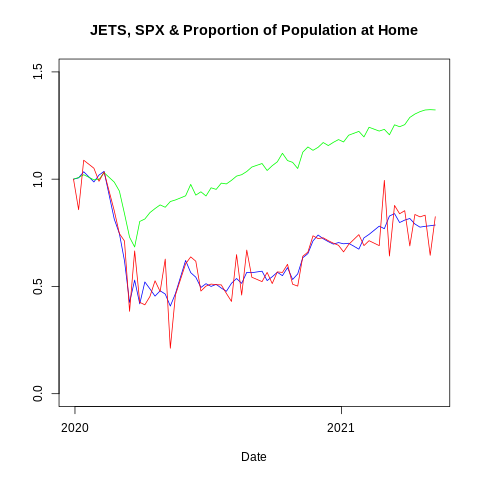

In [14]:
%%R
plot(x = visits_jets[,1], y = visits_jets$JETS_rebased, ylim = c(0,1.5), type = "l", col = "blue", xlab = "Date", ylab = "", main = "JETS, SPX & Proportion of Population at Home")
lines(x = visits_jets[,1], y = visits_jets$SPX_rebased, type = "l", col = "green")
lines(x = visits_jets[,1], y = visits_jets$PROP_change+visits_jets[, 11]-1, type = "l", col = "red")

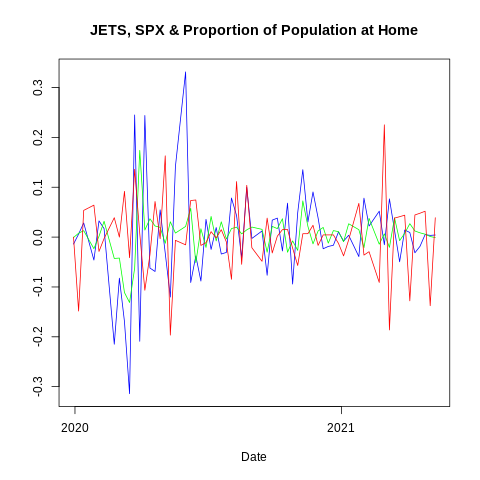

In [15]:
%%R
plot(x = visits_jets$date, y = visits_jets$jets_ret, type = "l", col = "blue", xlab = "Date", ylab = "", main = "JETS, SPX & Proportion of Population at Home")
lines(x = visits_jets$date, y = visits_jets$spx_ret, type = "l", col = "green")
lines(x = visits_jets$date, y = visits_jets$PROP_change-1, type = "l", col = "red")

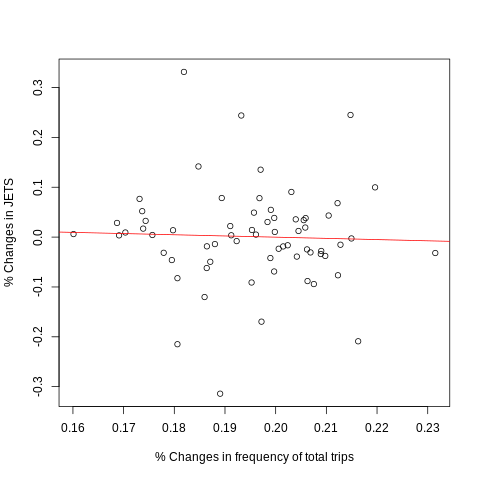

In [16]:
%%R
model = lm(visits_jets$jets_ret ~ visits_jets$prop)

plot(visits_jets$jets_ret ~ visits_jets$prop, xlab = "% Changes in frequency of total trips", ylab = "% Changes in JETS")
abline(model, col="red")

In [17]:
%%R
summary(model)


Call:
lm(formula = visits_jets$jets_ret ~ visits_jets$prop)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31655 -0.03628 -0.00019  0.03811  0.32718 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)       0.04804    0.16519   0.291    0.772
visits_jets$prop -0.24124    0.84353  -0.286    0.776

Residual standard error: 0.09863 on 64 degrees of freedom
Multiple R-squared:  0.001276,	Adjusted R-squared:  -0.01433 
F-statistic: 0.08179 on 1 and 64 DF,  p-value: 0.7758



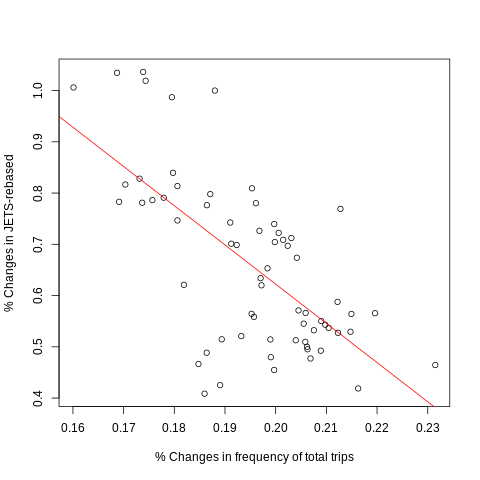

In [18]:
%%R
model2 = lm(visits_jets$JETS_rebased ~ visits_jets$prop)

plot(visits_jets$JETS_rebased ~ visits_jets$prop, xlab = "% Changes in frequency of total trips", ylab = "% Changes in JETS-rebased")
abline(model2, col="red")

In [19]:
%%R
summary(model2)


Call:
lm(formula = visits_jets$JETS_rebased ~ visits_jets$prop)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.32109 -0.07557 -0.00207  0.08053  0.28598 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.1529     0.2084  10.332 2.87e-15 ***
visits_jets$prop  -7.6531     1.0641  -7.192 8.55e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1244 on 64 degrees of freedom
Multiple R-squared:  0.447,	Adjusted R-squared:  0.4383 
F-statistic: 51.73 on 1 and 64 DF,  p-value: 8.545e-10



# Trips by Distance

## Total Trips

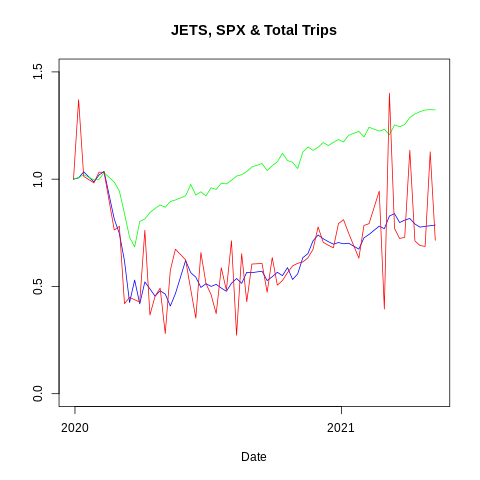

In [49]:
%%R
plot(x = visits_jets[,1], y = visits_jets$JETS_rebased, ylim = c(0,1.5), type = "l", col = "blue", xlab = "Date", ylab = "", main = "JETS, SPX & Total Trips")
lines(x = visits_jets[,1], y = visits_jets$SPX_rebased, type = "l", col = "green")
lines(x = visits_jets[,1], y = visits_jets$TOT_change+visits_jets[, 11]-1, type = "l", col = "red")

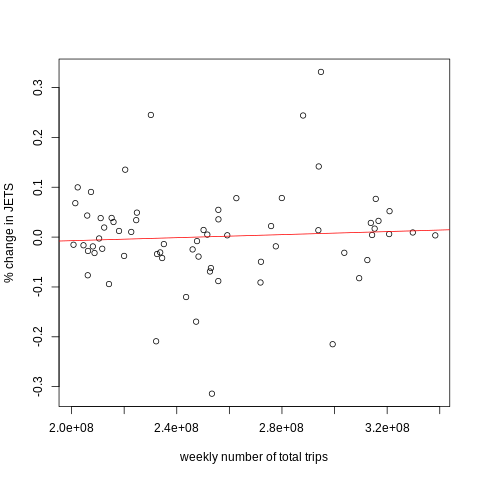

In [21]:
%%R
model_TOT1 = lm(visits_jets$jets_ret ~ visits_jets$tot_trips)

plot(visits_jets$jets_ret ~ visits_jets$tot_trips, xlab = "weekly number of total trips", ylab = "% change in JETS")
abline(model_TOT1, col="red")

In [22]:
%%R
summary(model_TOT1)


Call:
lm(formula = visits_jets$jets_ret ~ visits_jets$tot_trips)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31507 -0.03787 -0.00424  0.03992  0.32408 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)
(Intercept)           -3.762e-02  7.797e-02  -0.482    0.631
visits_jets$tot_trips  1.522e-10  3.042e-10   0.500    0.618

Residual standard error: 0.0985 on 64 degrees of freedom
Multiple R-squared:  0.003898,	Adjusted R-squared:  -0.01167 
F-statistic: 0.2504 on 1 and 64 DF,  p-value: 0.6185



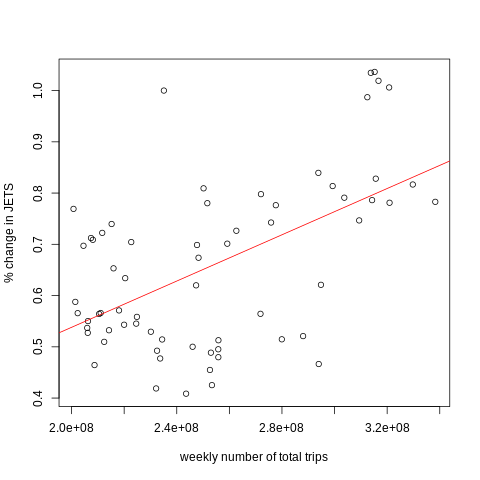

In [23]:
%%R
model_TOT2 = lm(visits_jets$JETS_rebased ~ visits_jets$tot_trips)

plot(visits_jets$JETS_rebased ~ visits_jets$tot_trips, xlab = "weekly number of total trips", ylab = "% change in JETS")
abline(model_TOT2, col="red")

In [24]:
%%R
summary(model_TOT2)


Call:
lm(formula = visits_jets$JETS_rebased ~ visits_jets$tot_trips)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28379 -0.09949 -0.00488  0.08691  0.38269 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           8.669e-02  1.109e-01   0.781    0.437    
visits_jets$tot_trips 2.257e-09  4.328e-10   5.215 2.11e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1402 on 64 degrees of freedom
Multiple R-squared:  0.2982,	Adjusted R-squared:  0.2873 
F-statistic:  27.2 on 1 and 64 DF,  p-value: 2.108e-06




Call:
lm(formula = visits_jets$jets_ret ~ visits_jets$PROP_change + 
    visits_jets$spx_ret)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27823 -0.03673 -0.00571  0.03385  0.32426 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)
(Intercept)              0.07688    0.16826   0.457    0.649
visits_jets$PROP_change -0.07730    0.16739  -0.462    0.646
visits_jets$spx_ret      0.29462    0.31255   0.943    0.349

Residual standard error: 0.09854 on 63 degrees of freedom
Multiple R-squared:  0.01858,	Adjusted R-squared:  -0.01258 
F-statistic: 0.5963 on 2 and 63 DF,  p-value: 0.5539



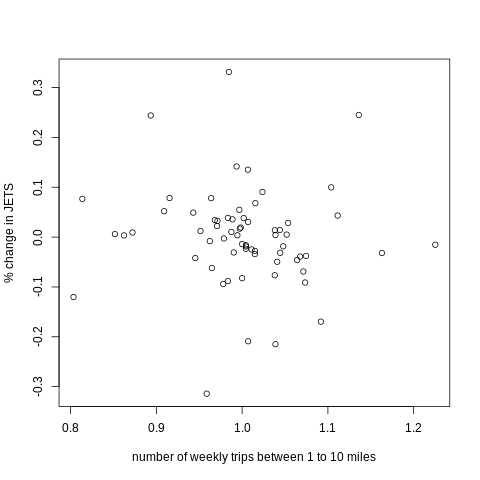

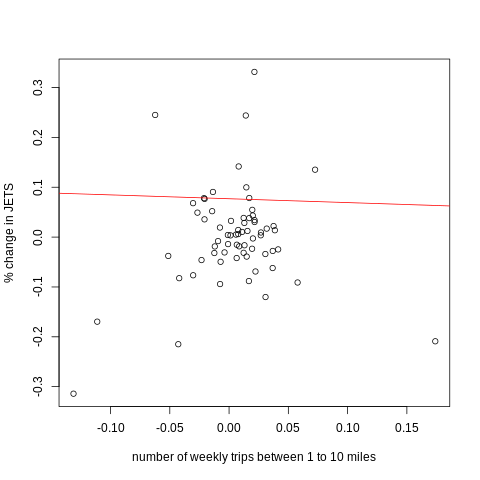

In [25]:
%%R
model_PROPCAPM = lm(visits_jets$jets_ret ~ visits_jets$PROP_change+visits_jets$spx_ret)

plot(visits_jets$jets_ret ~ visits_jets$PROP_change+visits_jets$spx_ret, xlab = "number of weekly trips between 1 to 10 miles", ylab = "% change in JETS")
abline(model_PROPCAPM, col="red")
summary(model_PROPCAPM)

## Short Trips

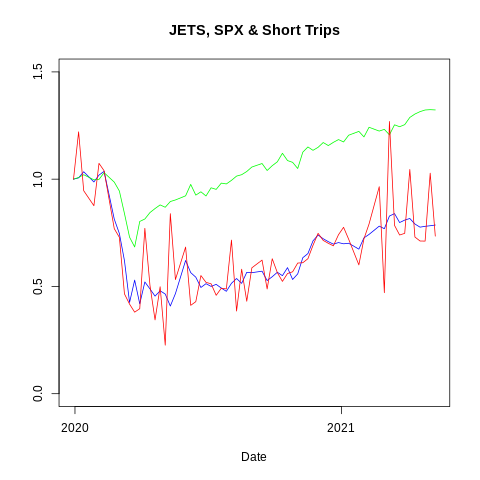

In [50]:
%%R
plot(x = visits_jets[,1], y = visits_jets$JETS_rebased, ylim = c(0,1.5), type = "l", col = "blue", xlab = "Date", ylab = "", main = "JETS, SPX & Short Trips")
lines(x = visits_jets[,1], y = visits_jets$SPX_rebased, type = "l", col = "green")
lines(x = visits_jets[,1], y = visits_jets$SHORT_change+visits_jets[, 11]-1, type = "l", col = "red")

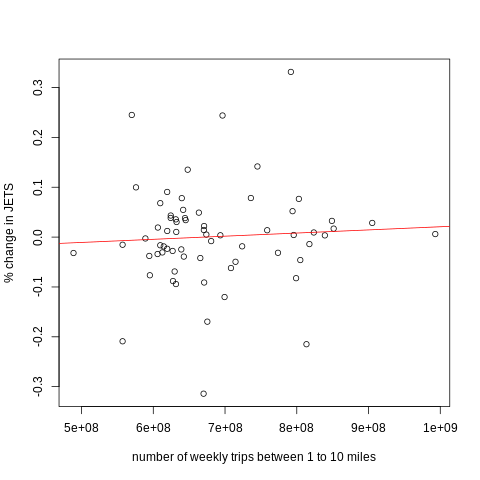

In [27]:
%%R
model_SHORT1 = lm(visits_jets$jets_ret ~ visits_jets$short_trips)

plot(visits_jets$jets_ret ~ visits_jets$short_trips, xlab = "number of weekly trips between 1 to 10 miles", ylab = "% change in JETS")
abline(model_SHORT1, col="red")

In [28]:
%%R
summary(model_SHORT1)


Call:
lm(formula = visits_jets$jets_ret ~ visits_jets$short_trips)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31414 -0.03631 -0.00208  0.03927  0.32367 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)
(Intercept)             -4.212e-02  8.891e-02  -0.474    0.637
visits_jets$short_trips  6.289e-11  1.287e-10   0.489    0.627

Residual standard error: 0.09851 on 64 degrees of freedom
Multiple R-squared:  0.003719,	Adjusted R-squared:  -0.01185 
F-statistic: 0.2389 on 1 and 64 DF,  p-value: 0.6267



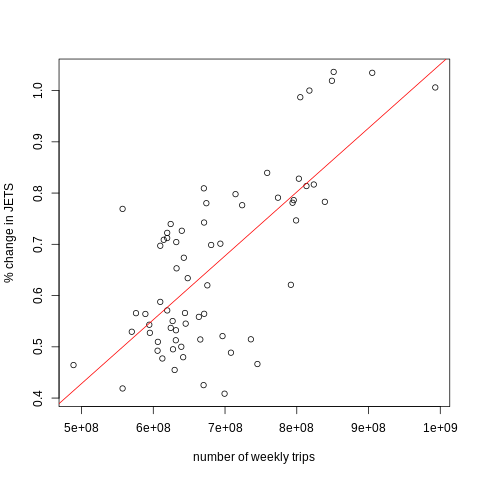

In [51]:
%%R
model_SHORT2 = lm(visits_jets$JETS_rebased ~ visits_jets$short_trips)

plot(visits_jets$JETS_rebased ~ visits_jets$short_trips, xlab = "number of weekly trips", ylab = "% change in JETS")
abline(model_SHORT2, col="red")

In [30]:
%%R
summary(model_SHORT2)


Call:
lm(formula = visits_jets$JETS_rebased ~ visits_jets$short_trips)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.268165 -0.072221 -0.005699  0.098198  0.269583 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.949e-01  1.059e-01  -1.841   0.0702 .  
visits_jets$short_trips  1.246e-09  1.532e-10   8.133 1.88e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1173 on 64 degrees of freedom
Multiple R-squared:  0.5083,	Adjusted R-squared:  0.5006 
F-statistic: 66.15 on 1 and 64 DF,  p-value: 1.877e-11




Call:
lm(formula = visits_jets$jets_ret ~ visits_jets$SHORT_change + 
    visits_jets$spx_ret)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27686 -0.03349 -0.00239  0.03532  0.31972 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)
(Intercept)              -0.11500    0.09672  -1.189    0.239
visits_jets$SHORT_change  0.11379    0.09545   1.192    0.238
visits_jets$spx_ret       0.26793    0.31010   0.864    0.391

Residual standard error: 0.09762 on 63 degrees of freedom
Multiple R-squared:  0.03698,	Adjusted R-squared:  0.006408 
F-statistic:  1.21 on 2 and 63 DF,  p-value: 0.3052



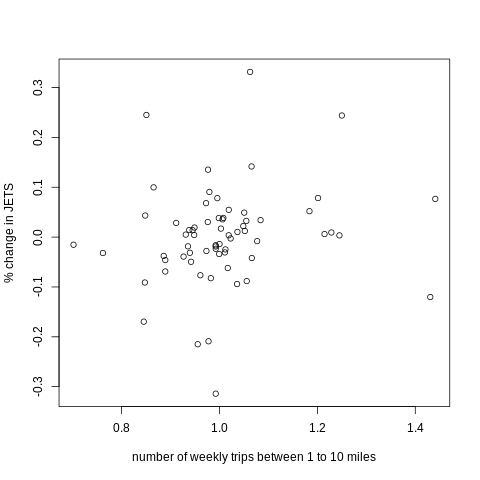

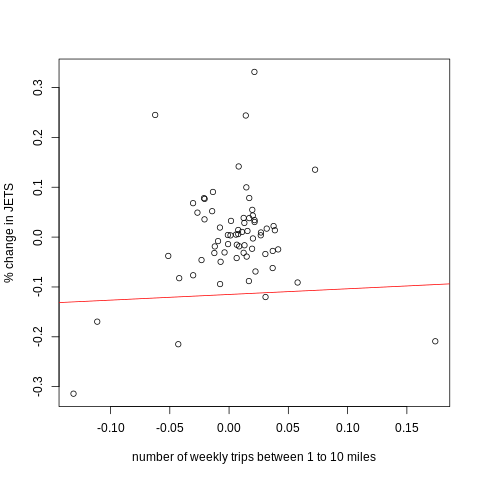

In [31]:
%%R
model_SHORTCAPM = lm(visits_jets$jets_ret ~ visits_jets$SHORT_change+visits_jets$spx_ret)

plot(visits_jets$jets_ret ~ visits_jets$SHORT_change+visits_jets$spx_ret, xlab = "number of weekly trips between 1 to 10 miles", ylab = "% change in JETS")
abline(model_SHORTCAPM, col="red")
summary(model_SHORTCAPM)

## Medium Trips

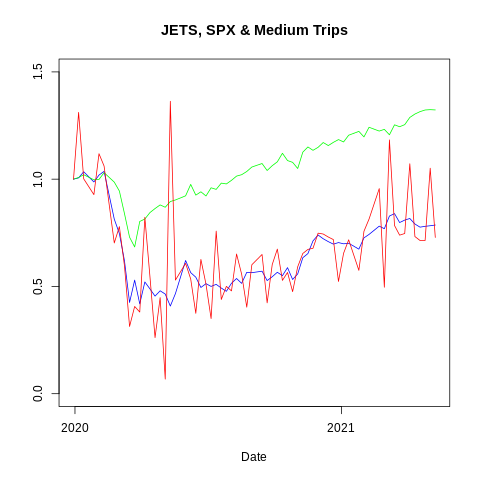

In [52]:
%%R
plot(x = visits_jets[,1], y = visits_jets$JETS_rebased, ylim = c(0,1.5), type = "l", col = "blue", xlab = "Date", ylab = "", main = "JETS, SPX & Medium Trips")
lines(x = visits_jets[,1], y = visits_jets$SPX_rebased, type = "l", col = "green")
lines(x = visits_jets[,1], y = visits_jets$MEDIUM_change+visits_jets[, 11]-1, type = "l", col = "red")

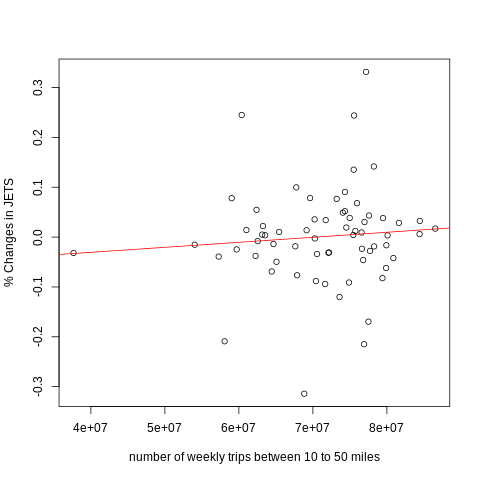

In [33]:
%%R
model_MEDIUM1 = lm(visits_jets$jets_ret ~ visits_jets$medium_trips)

plot(visits_jets$jets_ret ~ visits_jets$medium_trips, xlab = "number of weekly trips between 10 to 50 miles", ylab = "% Changes in JETS")
abline(model_MEDIUM1, col="red")

In [34]:
%%R
summary(model_MEDIUM1)


Call:
lm(formula = visits_jets$jets_ret ~ visits_jets$medium_trips)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31260 -0.03395  0.00082  0.03347  0.32445 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)
(Intercept)              -7.076e-02  1.033e-01  -0.685    0.496
visits_jets$medium_trips  1.006e-09  1.440e-09   0.699    0.487

Residual standard error: 0.09832 on 64 degrees of freedom
Multiple R-squared:  0.007569,	Adjusted R-squared:  -0.007938 
F-statistic: 0.4881 on 1 and 64 DF,  p-value: 0.4873



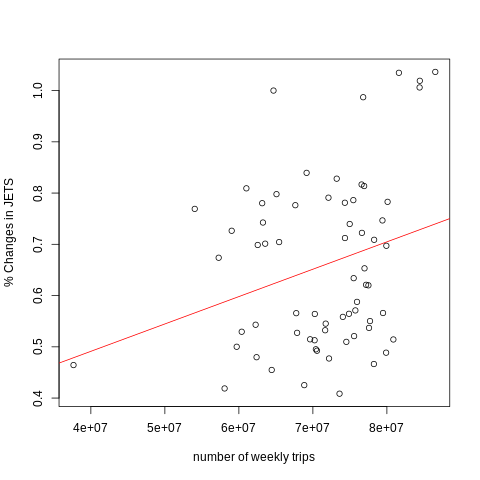

In [53]:
%%R
model_MEDIUM = lm(visits_jets$JETS_rebased ~ visits_jets$medium_trips)

plot(visits_jets$JETS_rebased ~ visits_jets$medium_trips, xlab = "number of weekly trips", ylab = "% Changes in JETS")
abline(model_MEDIUM, col="red")

In [36]:
%%R
summary(model_MEDIUM)


Call:
lm(formula = visits_jets$JETS_rebased ~ visits_jets$medium_trips)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26216 -0.13393 -0.04129  0.12660  0.37694 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)  
(Intercept)              2.777e-01  1.692e-01   1.641   0.1056  
visits_jets$medium_trips 5.340e-09  2.358e-09   2.265   0.0269 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.161 on 64 degrees of freedom
Multiple R-squared:  0.07422,	Adjusted R-squared:  0.05976 
F-statistic: 5.131 on 1 and 64 DF,  p-value: 0.02689




Call:
lm(formula = visits_jets$jets_ret ~ visits_jets$MEDIUM_change + 
    visits_jets$spx_ret)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27120 -0.03631 -0.00458  0.03318  0.32684 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)
(Intercept)               -0.03968    0.07205  -0.551    0.584
visits_jets$MEDIUM_change  0.03860    0.07014   0.550    0.584
visits_jets$spx_ret        0.28584    0.31358   0.912    0.365

Residual standard error: 0.09847 on 63 degrees of freedom
Multiple R-squared:  0.01997,	Adjusted R-squared:  -0.01115 
F-statistic: 0.6417 on 2 and 63 DF,  p-value: 0.5298



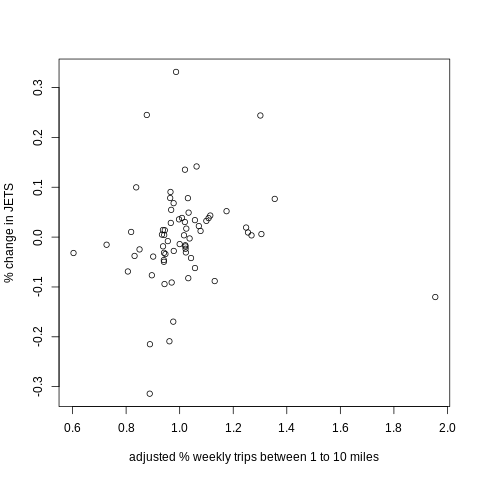

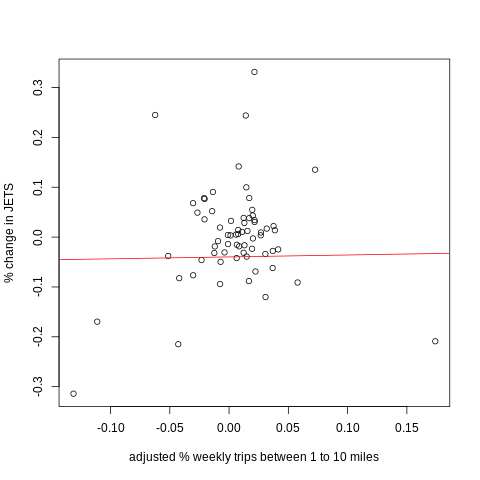

In [37]:
%%R
model_MEDIUMCAPM = lm(visits_jets$jets_ret ~ visits_jets$MEDIUM_change+visits_jets$spx_ret)

plot(visits_jets$jets_ret ~ visits_jets$MEDIUM_change+visits_jets$spx_ret, xlab = "adjusted % weekly trips between 1 to 10 miles", ylab = "% change in JETS")
abline(model_MEDIUMCAPM, col="red")
summary(model_MEDIUMCAPM)


Call:
lm(formula = visits_jets$JETS_rebased ~ visits_jets$MEDIUM_change + 
    visits_jets$SPX_rebased)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.16999 -0.09313 -0.03243  0.02734  0.39930 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                0.04424    0.16023   0.276    0.783    
visits_jets$MEDIUM_change  0.01404    0.10125   0.139    0.890    
visits_jets$SPX_rebased    0.56579    0.11507   4.917 6.61e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1433 on 63 degrees of freedom
Multiple R-squared:  0.2775,	Adjusted R-squared:  0.2546 
F-statistic:  12.1 on 2 and 63 DF,  p-value: 3.574e-05



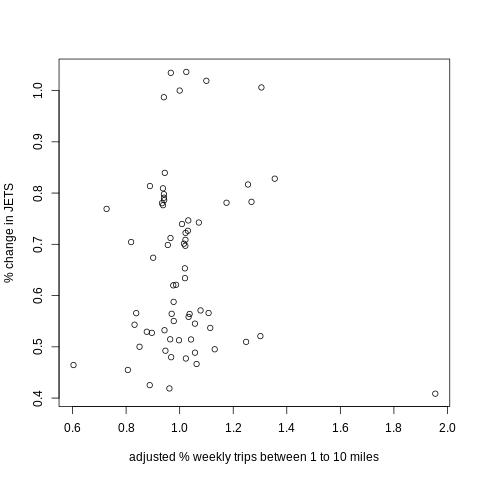

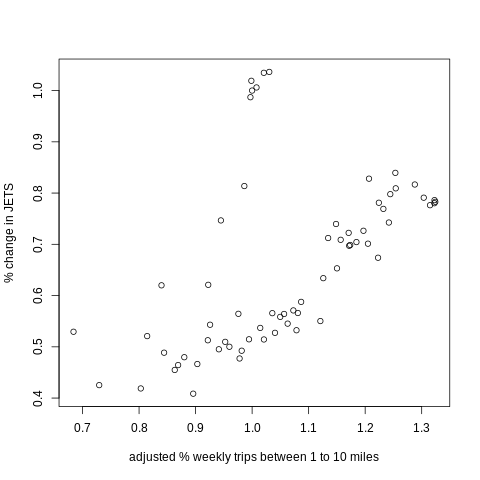

In [38]:
%%R
model_MEDIUMCAPM2 = lm(visits_jets$JETS_rebased ~ visits_jets$MEDIUM_change+visits_jets$SPX_rebased)

plot(visits_jets$JETS_rebased ~ visits_jets$MEDIUM_change+visits_jets$SPX_rebased, xlab = "adjusted % weekly trips between 1 to 10 miles", ylab = "% change in JETS")
abline(model_MEDIUMCAPM2, col="red")
summary(model_MEDIUMCAPM2)

## Long Trips

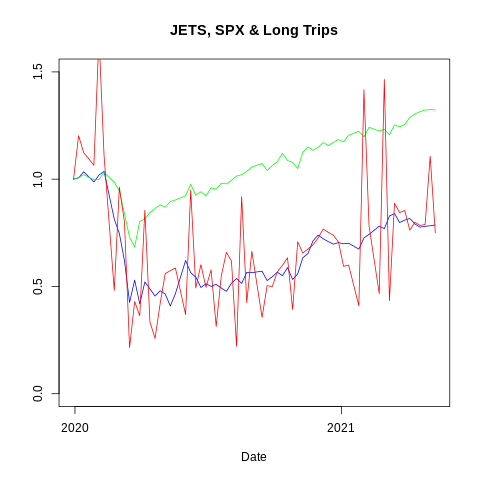

In [54]:
%%R
plot(x = visits_jets[,1], y = visits_jets$JETS_rebased, ylim = c(0,1.5), type = "l", col = "blue", xlab = "Date", ylab = "", main = "JETS, SPX & Long Trips")
lines(x = visits_jets[,1], y = visits_jets$SPX_rebased, type = "l", col = "green")
lines(x = visits_jets[,1], y = visits_jets$LONG_change+visits_jets[, 11]-1, type = "l", col = "red")

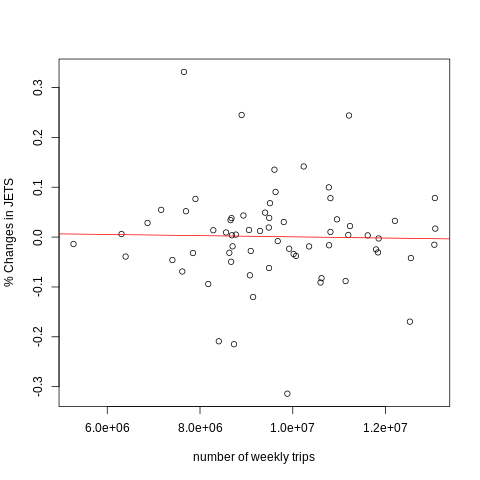

In [55]:
%%R
model_LONG1 = lm(visits_jets$jets_ret ~ visits_jets$long_trips)

plot(visits_jets$jets_ret ~ visits_jets$long_trips, xlab = "number of weekly trips", ylab = "% Changes in JETS")
abline(model_LONG1, col="red")

In [41]:
%%R
summary(model_LONG1)


Call:
lm(formula = visits_jets$jets_ret ~ visits_jets$long_trips)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31473 -0.03738  0.00231  0.03619  0.32806 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)
(Intercept)             1.246e-02  6.979e-02   0.179    0.859
visits_jets$long_trips -1.199e-09  7.144e-09  -0.168    0.867

Residual standard error: 0.09867 on 64 degrees of freedom
Multiple R-squared:  0.0004396,	Adjusted R-squared:  -0.01518 
F-statistic: 0.02815 on 1 and 64 DF,  p-value: 0.8673



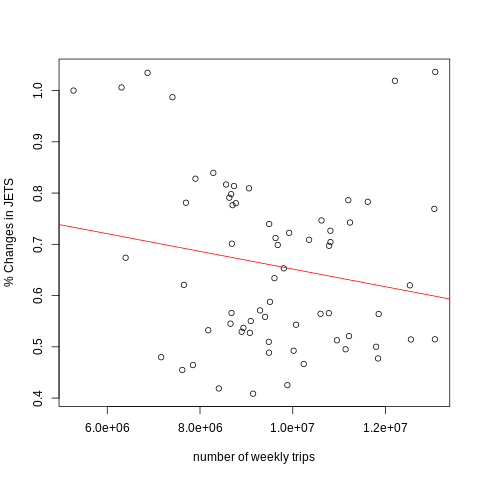

In [57]:
%%R
model_LONG2 = lm(visits_jets$JETS_rebased ~ visits_jets$long_trips)

plot(visits_jets$JETS_rebased ~ visits_jets$long_trips, xlab = "number of weekly trips", ylab = "% Changes in JETS")
abline(model_LONG2, col="red")

In [43]:
%%R
summary(model_LONG2)


Call:
lm(formula = visits_jets$JETS_rebased ~ visits_jets$long_trips)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26041 -0.12780 -0.03228  0.11096  0.43777 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             8.241e-01  1.164e-01   7.078 1.36e-09 ***
visits_jets$long_trips -1.725e-08  1.192e-08  -1.447    0.153    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1646 on 64 degrees of freedom
Multiple R-squared:  0.03168,	Adjusted R-squared:  0.01655 
F-statistic: 2.094 on 1 and 64 DF,  p-value: 0.1528



## Super Trips

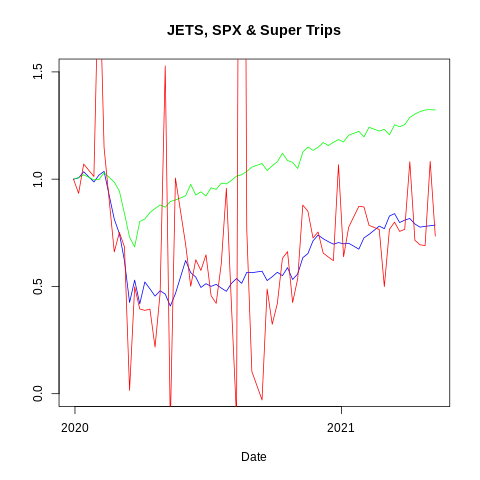

In [56]:
%%R
plot(x = visits_jets[,1], y = visits_jets$JETS_rebased, ylim = c(0,1.5), type = "l", col = "blue", xlab = "Date", ylab = "", main = "JETS, SPX & Super Trips")
lines(x = visits_jets[,1], y = visits_jets$SPX_rebased, type = "l", col = "green")
lines(x = visits_jets[,1], y = visits_jets$SUPER_change+visits_jets[, 11]-1, type = "l", col = "red")

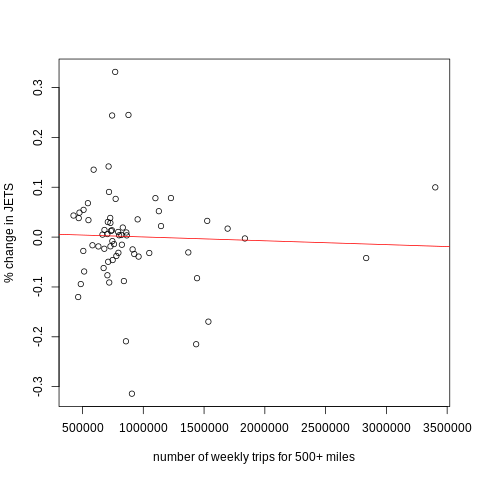

In [45]:
%%R
model_SUPER1 = lm(visits_jets$jets_ret ~ visits_jets$super_trips)

plot(visits_jets$jets_ret ~ visits_jets$super_trips, xlab = "number of weekly trips for 500+ miles", ylab = "% change in JETS")
abline(model_SUPER1, col="red")

In [46]:
%%R
summary(model_SUPER1)


Call:
lm(formula = visits_jets$jets_ret ~ visits_jets$super_trips)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31506 -0.03439  0.00240  0.03583  0.32934 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)
(Intercept)              7.921e-03  2.541e-02   0.312    0.756
visits_jets$super_trips -7.697e-09  2.457e-08  -0.313    0.755

Residual standard error: 0.09862 on 64 degrees of freedom
Multiple R-squared:  0.001531,	Adjusted R-squared:  -0.01407 
F-statistic: 0.09813 on 1 and 64 DF,  p-value: 0.7551



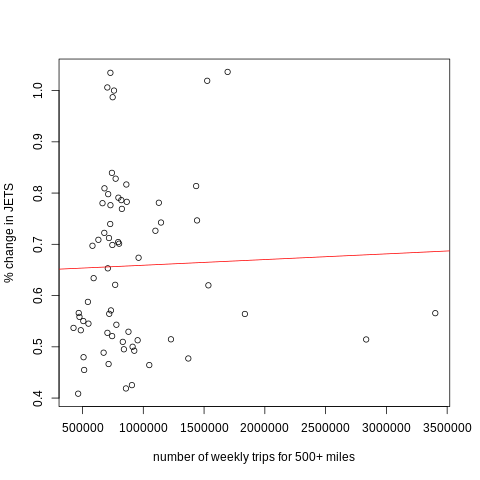

In [47]:
%%R
model_SUPER2 = lm(visits_jets$JETS_rebased ~ visits_jets$super_trips)

plot(visits_jets$JETS_rebased ~ visits_jets$super_trips, xlab = "number of weekly trips for 500+ miles", ylab = "% change in JETS")
abline(model_SUPER2, col="red")

In [48]:
%%R
summary(model_SUPER2)


Call:
lm(formula = visits_jets$JETS_rebased ~ visits_jets$super_trips)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24475 -0.13379 -0.02823  0.12036  0.37842 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             6.481e-01  4.308e-02  15.046   <2e-16 ***
visits_jets$super_trips 1.109e-08  4.166e-08   0.266    0.791    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1672 on 64 degrees of freedom
Multiple R-squared:  0.001107,	Adjusted R-squared:  -0.0145 
F-statistic: 0.0709 on 1 and 64 DF,  p-value: 0.7909

